## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_shared_experience"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

## Model Creation

### Re-usable Functions

To create a random forest model and to perform k-fold cross validation.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    random_state: int | None = None,
):
    # Model creation and predictions.
    if random_state is None:
        random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [3]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(
    _df: pd.DataFrame,
    predictor_fields: Iterator[str],
    k: int = 5
):
    random_state = seed_counter.get_next()

    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        _, rf_metrics = create_model(
            train_predictors,
            train_labels,
            test_predictors,
            test_labels,
            random_state
        )
        return rf_metrics

    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=seed_counter.get_next()
    )
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 12),
        return_results=True,
        print_lifetime_events=False
    )

    f1_scores = [entry['f1'] for entry in models_and_f1s]
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return f1_scores, f1_mean, f1_std


### Full Model

In [4]:
f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields)

print("\nPerformance metrics full model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')


random_state=43
random_state=43
random_state=43random_state=43random_state=43


metrics={'accuracy': 0.9065859009562182, 'precision': 0.9211155012404668, 'recall': 0.9737881682479034, 'f1': 0.9467197632689038}

Confusion matrix:
[[ 5556  5151]
 [ 1619 60147]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.52      0.62     10707
        True       0.92      0.97      0.95     61766

    accuracy                           0.91     72473
   macro avg       0.85      0.75      0.78     72473
weighted avg       0.90      0.91      0.90     72473

metrics={'accuracy': 0.9053565514957501, 'precision': 0.9206081857018175, 'recall': 0.9729117447166575, 'f1': 0.9460375903766117}

Confusion matrix:
[[ 5489  5185]
 [ 1674 60124]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.51      0.62     10674
        True       0.92      0.97      0.95     61798

    accuracy         

### Control + Intra-project Model

In [5]:
# Creates control model + Intra fields.
contr_with_intra = [field for field in independent_fields
                    if re.match(r'.*(Control|Intra).*',field)]
contr_with_intra = list(contr_with_intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)

print("\nPerformance metrics control + intra model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
random_state=45random_state=45random_state=45


random_state=45
random_state=45
metrics={'accuracy': 0.8956576932098851, 'precision': 0.9186872813034699, 'recall': 0.9630443564676416, 'f1': 0.9403430158254312}

Confusion matrix:
[[ 5313  5275]
 [ 2287 59598]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.50      0.58     10588
        True       0.92      0.96      

### Collaboration and Ecosystem Model

In [6]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in independent_fields
                               if not re.match(r'.*(Intra|Control).*', field)]
non_control_fields_wo_intra = list(non_control_fields_wo_intra)
print(non_control_fields_wo_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_fields_wo_intra)

print("\nPerformance metrics non-control model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)',

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [7]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


random_state=49
metrics={'accuracy': 0.9079795234087177, 'precision': 0.9224253913894325, 'recall': 0.9742446995753201, 'f1': 0.9476271625686171}

Confusion matrix:
[[ 5470  5074]
 [ 1595 60334]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.52      0.62     10544
        True       0.92      0.97      0.95     61929

    accuracy                           0.91     72473
   macro avg       0.85      0.75      0.78     72473
weighted avg       0.90      0.91      0.90     72473



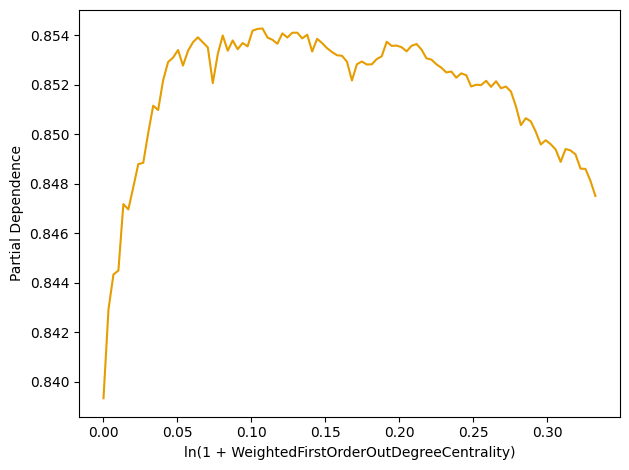

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

full_rf_model, _ = create_model(
    train_predictors, train_dependent,
    test_predictors, test_dependent
)

create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    model_name="full_model"
)


### Mean decrease in Impurity

/tmp/ipykernel_10052/2882849337.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


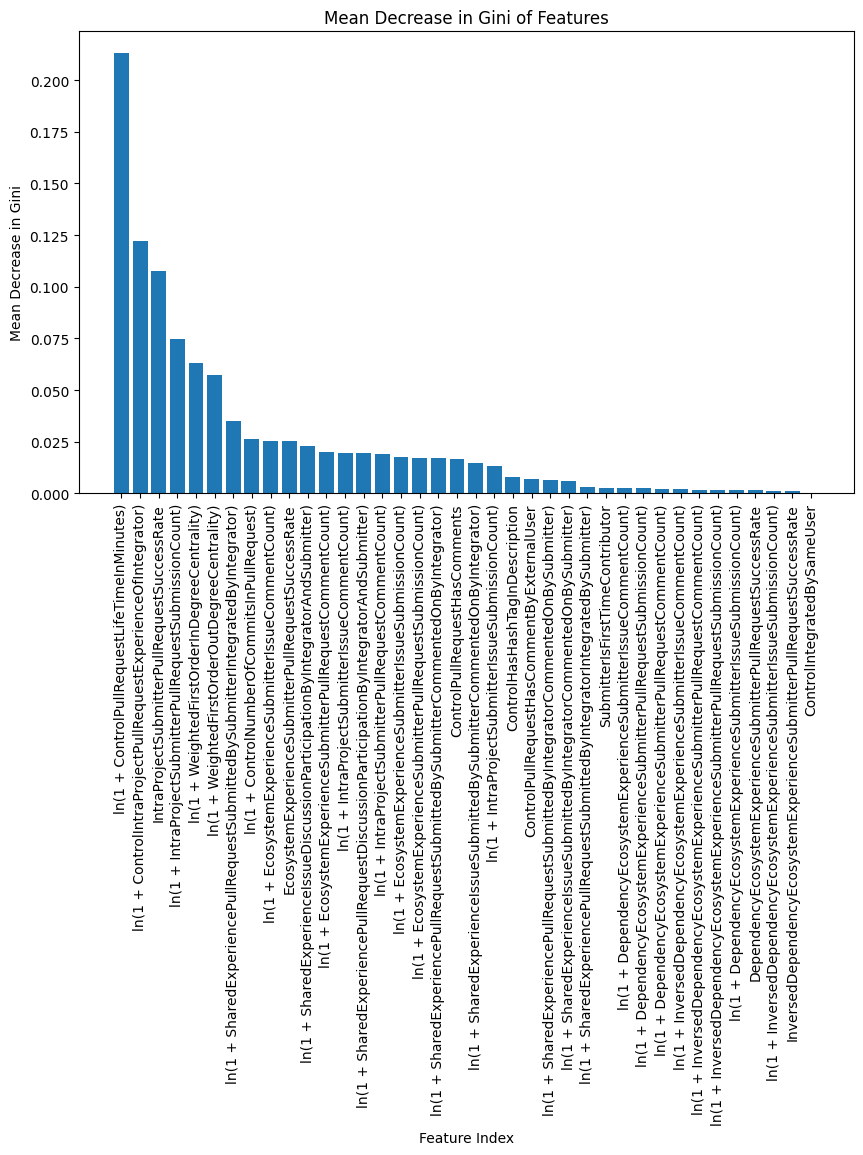

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.2129
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1223
IntraProjectSubmitterPullRequestSuccessRate: 0.1077
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.0746
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0631
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0570
ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator): 0.0351
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0265
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0253
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0251
ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter): 0.0231
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0201
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0197
ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter): 0.0195
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0190
ln(1 + EcosystemExperienceSubmitterIs

In [9]:
feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Gini')
plt.title('Mean Decrease in Gini of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')


### Cluster Ablation

Removes clusters of features from the dataset and tests their impact on the performance.

In [10]:
from python_proj.utils.util import get_matching

control_features = get_matching(independent_fields, r'.*Control.*')
intra_features = get_matching(
    independent_fields, r'^(?!.*Control).*(?=Intra).*')
eco_features = get_matching(
    independent_fields, r'^(?!.*Dependency).*(?=Ecosystem).*')
deco_features = get_matching(
    independent_fields, r'^(?!.*Inverse).*(?=Dependency).*')
ideco_features = get_matching(independent_fields, r'.*(?=Inverse).*')
coll_features = get_matching(independent_fields, r'.*(Weighted|Shared).*')

clusters = [
    ('control', control_features),
    ("intra", intra_features),
    ("eco", eco_features),
    ("deco", deco_features),
    ("ideco", ideco_features),
    ("coll", coll_features)
]

results = {}
for (cluster_name, cluster) in clusters:
    cluster = list(cluster)
    print(
        f'Starting cluster ablation with "{cluster_name}" fields excluded: {list(cluster)}.')
    used_fields = [field for field in independent_fields
                   if field not in cluster]
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, cluster)
    results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f'Performance metrics of cluster {cluster_name}\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')

for cluster_name, (f1_scores, f1_mean, f1_std) in results.items():
    print(
        f'Performance metrics of cluster {cluster_name}\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')


Starting cluster ablation with "control" fields excluded: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=50
random_state=50random_state=50

random_state=50
random_state=50
metrics={'accuracy': 0.848907164146153, 'precision': 0.8861457589523101, 'recall': 0.9440622825048962, 'f1': 0.914187643020595}

Confusion matrix:
[[ 3195  7494]
 [ 3456 58327]]

Classification report:
              precision    recall  f1-score   support

       False       0.48      0.30      0.37     10689
        True       0.89      0.94      0.91     61783

    accuracy                           0.85     72472
   macro avg       0.68      0.62      0.64     72472
weighted avg       0.83      0.85      0.83     72472

metrics={'accuracy': 0.851970

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [11]:
import random

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [
    random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=:.03f}.")
print(json.dumps(metrics, indent=4))


Probability guesser metrics with probability_true=0.854.
{
    "accuracy": 0.7489547831606254,
    "precision": 0.8542270746602304,
    "recall": 0.8515235188683815,
    "f1": 0.8528731542430172
}
